In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime, os, glob, json, string, inspect, emcee
from scipy.stats import median_abs_deviation, poisson
from matplotlib.patches import Circle, Ellipse
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from astropy.io import ascii, fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from PyDynamic import interp1d_unc
from astropy.table import Table
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import pickle as p

## Define the functions

In [3]:
# Functions from the Hardness analysis that filters/Cleans the light curves for MAXI/GSC and Swift-BAT
def filter_times(lc, ti, tf):
    '''
    Take an input lc array and return
    a time filtered array, input/output arrrays:
        0 -- Time (MJD)
        1 -- Rate (counts/s/cm^2)
        2 -- error on rate (counts/s/cm^2)
    '''
    
    # Get index
    index = np.where((lc[:,0] > ti) & (lc[:,0] < tf))[0]
        
    #Return filtered array
    return lc[index,:]

def filter_errors(lc):
    '''
    Take the input lc and filter any data points
    that are greater than 2 standard deviations
    from the median value
    '''
    
    index = np.where(lc[:,2] < np.median(lc[:,2]) + 3.0 * np.std(lc[:,2], ddof = 1))[0]
    
    # Return good values 
    return lc[index,:]


## Load in and filter the results

In [7]:
# Times -- 2016 outburst https://www.aanda.org/articles/aa/full_html/2018/08/aa32693-18/aa32693-18.html
ti = 57590
tf = 57660

Observations = Time(['2016-08-03T03:15:00', '2016-08-05T02:45:00', '2016-08-07T17:26:00', '2016-09-19T14:20:00'], format='isot', scale='utc').datetime
ss_index = [1,2]

# Swift-BAT light curve [15-50keV] -- columns: Time, Rate, Error
bat  = np.loadtxt('../../analysis/bat-maxi/results/Aql_filtered_bat.txt')
bat  = filter_errors(filter_times(bat, ti, tf))

# MAXI/GSC light curve [4-10keV]
maxi = np.loadtxt('../../analysis/bat-maxi/results/Aql_filtered_maxi.txt')
maxi = filter_errors(filter_times(maxi, ti, tf))

# Hardness ratio 
HR   = np.loadtxt('../../analysis/bat-maxi/results/Aql_HR_fits.txt')
HR   = filter_times(HR, ti, tf)

#Swift-BAT and MAXI/GSC HR Ratio
HR_data = filter_times(np.loadtxt('../../analysis/bat-maxi/results/Aql_HR_fits.txt'), ti, tf)
de = np.where(HR_data[:,-1].astype(int) == 0)[0]  # Detection indexes (Both > 3-sigma)
ll  = np.where(HR_data[:,-1].astype(int) == 1)[0] # Lower-Limit (BAT > 3-sigma)

## Plot the HR ratio for Aql X-1

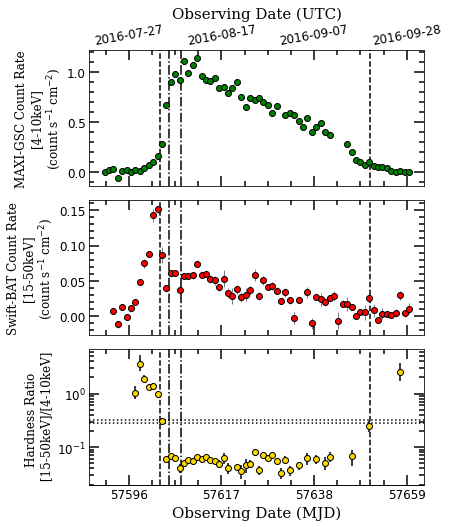

In [8]:
# Plot the Light Curves
fig,ax = plt.subplots(3,figsize=(6,8),sharex='col',gridspec_kw={'hspace': 0.1, 'wspace': 0})

# Maxi Count Rate
ax[0].errorbar(Time(maxi[:,0], format='mjd').datetime, maxi[:,1], yerr=maxi[:,2], fmt='o', mec='k', mew=1.0, ecolor='k', lw=0.5, c='green')
ax[0].set_ylabel('MAXI-GSC Count Rate\n[4-10keV]\n(count s$^{-1}$ cm$^{-2}$)', fontsize=12,fontfamily='serif')

# Bat Count Rate
ax[1].errorbar(Time(bat[:,0] + 0.5, format='mjd').datetime, bat[:,1], yerr=bat[:,2],fmt='o', mec='k', mew=1.0, ecolor='k', lw=0.5, c='red')
ax[1].set_ylabel('Swift-BAT Count Rate\n[15-50keV]\n(count s$^{-1}$ cm$^{-2}$)', fontsize=12,fontfamily='serif')

# Hardness Ratio
ax[2].errorbar(Time(HR_data[:,0][de], format='mjd').datetime,HR_data[:,1][de],yerr=[HR_data[:,2][de],HR_data[:,3][de]], fmt='o', c='gold', ecolor='k',mec='k')
ax[2].set_ylabel('Hardness Ratio \n [15-50keV]/[4-10keV]', fontsize=12,fontfamily='serif')
ax[2].set_yscale('log')
ax[2].axhline(0.3204, ls=':', c='k')  
ax[2].axhline(0.2846, ls=':', c='k')  


# Make it pretty
for ax_i in ax:
    ax_i.xaxis.set_minor_locator(AutoMinorLocator(3))
    ax_i.tick_params(axis='both', which='minor', direction='in',length=5,width=1.5,top=True,right=True)
    ax_i.tick_params(axis='both', which='major', direction='in',length=10,width=1.5,top=True,right=True, labelsize=12, labelbottom=False)
    ax_i.minorticks_on()
    
    for i, obs in enumerate(Observations):
        if i in ss_index:
            ax_i.axvline(obs, ls='-.', c='k')
        else:
            ax_i.axvline(obs, ls='--', c='k')
            
def plot2mjd(t):
    '''Convert from matplotlib plot date to mjd'''
    return Time(t, format="plot_date", scale='utc').mjd


def mjd2plot(mjd):
    '''Convert from mjd to matplotlib plot'''
    return Time(mjd, format="mjd", scale='utc').plot_date

# Format primary x-axis
ax[0].set_xlabel('Observing Date (UTC)', fontsize=15, fontfamily='serif')    
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=21))
ax[0].xaxis.set_label_position('top') 
xformatter = mdates.DateFormatter('%Y-%m-%d')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
ax[0].tick_params(axis='x', which='major',rotation=10, labelsize=12 ,labeltop=True, labelbottom=False)

# Format secondary x-axis
mjd_ax = ax[-1].secondary_xaxis('bottom', functions=(plot2mjd, mjd2plot))
mjd_ax.set_xlabel('Observing Date (MJD)', fontsize=15, fontfamily='serif')  
mjd_ax.tick_params(which='major', direction='in', length = 0.0, width = 0.0, labelsize=12)
plt.draw()

# Extract the labels
mjd_ticks = []
labels = ax[0].get_xticklabels(which='major')
for lab in labels:
    mjd_ticks.append(lab.get_text() + 'T00:00:00')

# Line up MJD and Datetime labels 
mjd_ticks = (Time(mjd_ticks, format='isot').mjd).astype(int)
mjd_ax.set_xticks(mjd_ticks, labels = mjd_ticks)
plt.show()
        
ax[-1].set_xlabel('Observing Date (MJD)', fontsize=15, fontfamily='serif') 
plt.show()